# Map Analysis III

## CosmoAndes 2018
### Adapted from notebook developed by
### Jeff McMahon and Renée Hložek for the 2016 CMB Data Analysis Summer School at the University of Michigan

# CMB Polarization

In this section we generalize our code to handle polarization.  This means creating T, E, and B maps following the same general procedure we used for genearting the T maps (but with a corelation between T and E).  We then tranform these maps into Q and U maps.  These calculations are carried out in the flat sky approximation, but the tretement in a curved sky is analogus. 

After simulating these maps we present the problems associated with a cut sky and the associated E-B mode mixing.  We then present Kendrick Smith's no-leak pseudo-$C_\ell$ estimator as one of the possible solutions to this mixing problem

## Incorporating previous bits of code

In [1]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

%cd ./
%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

/Users/mp74207/GitHub/TheHypergeometricalUniverseNew


We also read in the constants for map noise, beam shape, and point sources so we can use these in the excercises

In [2]:
N = cs.N
N_iterations = cs.N_iterations
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = 0 #cs.atmospheric_noise_level
one_over_f_noise_level = 0 #cs.one_over_f_noise_level

## we will need a window funciton below, so we create it here
window = (cosine_window(N))

## Read in and plot the TT, EE, BB, and TE power spectra

With polarization there are four cosmologial power spectra to work with.   As you can see here, the main challenge is handling four times the book keeping.

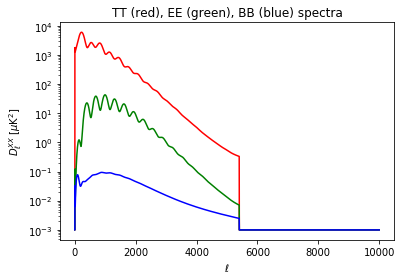

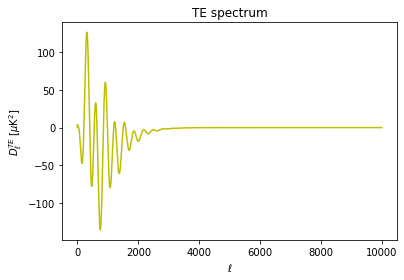

In [3]:
nbig = 10000
# read in the input CMB spectra
ell, DlTT,DlEE,DlBB, DlTE= np.loadtxt("CMB_fiducial_totalCls.dat", usecols=(0, 1,2,3,4), unpack=True) 

##
ell_big = np.arange(nbig)
DlTT_big = np.zeros(nbig)
DlTT_big[ell.astype(int)] = DlTT
DlEE_big = np.zeros(nbig)
DlEE_big[ell.astype(int)] = DlEE
DlBB_big = np.zeros(nbig)
DlBB_big[ell.astype(int)] = DlBB
DlTE_big = np.zeros(nbig)
DlTE_big[ell.astype(int)] = DlTE

ell = ell_big
DlTT = DlTT_big + 1e-3   ### the 1e-3 factor maps plotting easy
DlEE = DlEE_big + 1e-3
DlBB = DlBB_big + 1e-3
DlTE = DlTE_big

Temp_point_source_spectrum = DlTT[3000]*(ell/3000.)**2.
Pol_point_source_spectrum = DlEE[4500]*(ell/4500.)**2.

DlTT_PS = DlTT + Temp_point_source_spectrum   ### these are used for computing the transer functions
DlEE_PS = DlEE + Pol_point_source_spectrum
DlBB_PS = DlBB + Pol_point_source_spectrum


plt.semilogy(ell,DlTT,'r')
plt.semilogy(ell,DlEE,'g')
plt.semilogy(ell,DlBB,'b')
plt.title('TT (red), EE (green), BB (blue) spectra')
plt.ylabel('$D^{XX}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(ell,DlTE,'y')
plt.ylabel('$D^{TE}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('TE spectrum')
plt.show()

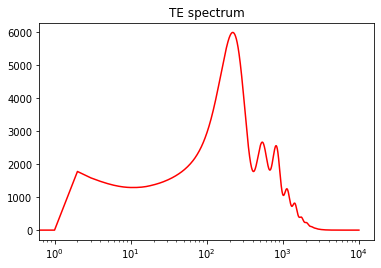

In [13]:
plt.semilogx(ell,DlTT,'r')
plt.title('TE spectrum')
plt.show()

These spectra probably look familure to you.   If you wish to explore the cosmological dependance of these spectra, you can simulate these spectra using CAMB on the NASA Lambda website just as we did in Part two of this course.  A key apsect for simmulation and analysis is that the information in the TT, EE, and BB are entirely contained in the T, E, and B maps, respectively;  while the TE information is contained within the T and E maps through a paritial coorlation that comes about from how the T and E fluctuations are sourced in the early universe.  We will have to build in this correlation when we simulate the tripled of T, E, and B maps

## Simulate T, E, and B maps

Here we introduce a function to create T, Q, and U maps.   To do this we follow the same procedure for creating T, E and B maps that we introduced in Part two of this course with the exception of introducing a T-E correlation.  We then trasnform into Q and U maps.

The correlation is introduced by (1) generating gaussian random fields for the T, B, and uncorelated part of the E maps; (2) sepearting the E-mode spectrum into a piece that is correlated with T: 
$$C_\ell^{EE, correlated} = r^2_\ell C_\ell^{EE} $$ 
where $$r_\ell = \frac {(C_\ell^{TE})} {\sqrt{C_\ell^{EE}C_\ell^{TT}}},$$ and a part that has represents the amplitude of the uncorrelated flucuations (chosen such that the correlated and uncorelated E- flucations reproeduce the EE spectrum: $$C_\ell^{uncorrelated} = (1-r^2_\ell) C_\ell^{EE};$$ and then generating the E- map as a sum of realizations of these two pieces.



The relation between E-B and Q-U maps is given by a position dependant rotation in fourier space.  We introduce an angle $\psi= \arctan \frac {k_Y} {k_X}$, where $k_X$ and $k_Y$ are the wave numbers in fourier space.   With this angle in had the relation between E-B and Q-U is:
$$\tilde Q  = \tilde E \cos 2 \psi - \tilde B \sin 2 \psi$$
$$\tilde U  = \tilde E \sin 2 \psi + \tilde B \cos 2 \psi$$.

The ~ over the Q, U, E, and B are to remind you that these quntities are in fourier space.  

As this is a simple rotation, the inverse transfom is:
$$\tilde E  = \tilde Q \cos 2 \psi + \tilde U \sin 2 \psi$$
$$\tilde B  = -\tilde Q \sin 2 \psi + \tilde U \cos 2 \psi$$.

/Users/mp74207/anaconda3/envs/cosmo36/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/mp74207/anaconda3/envs/cosmo36/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/mp74207/anaconda3/envs/cosmo36/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/mp74207/anaconda3/envs/cosmo36/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/mp74207/anaconda3/envs/cosmo36/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/Users/mp74207/anaconda3/envs/cosmo36/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


map mean: 30.91378047690676 map rms: 100.56139400053043


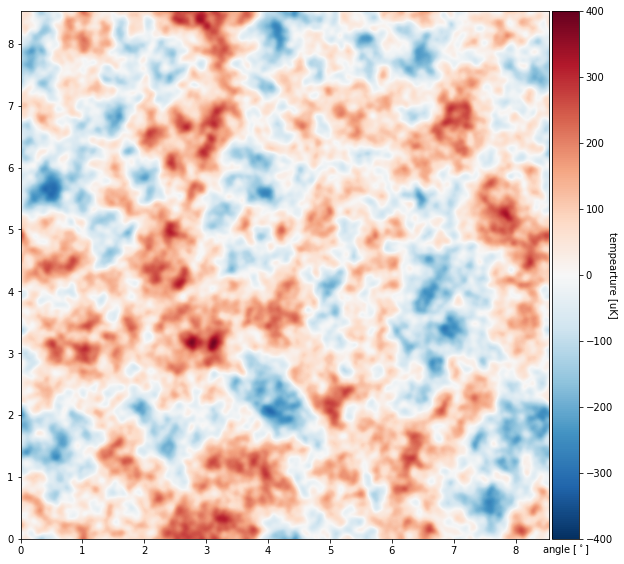

map mean: -0.092520028869164 map rms: 4.531481519946306


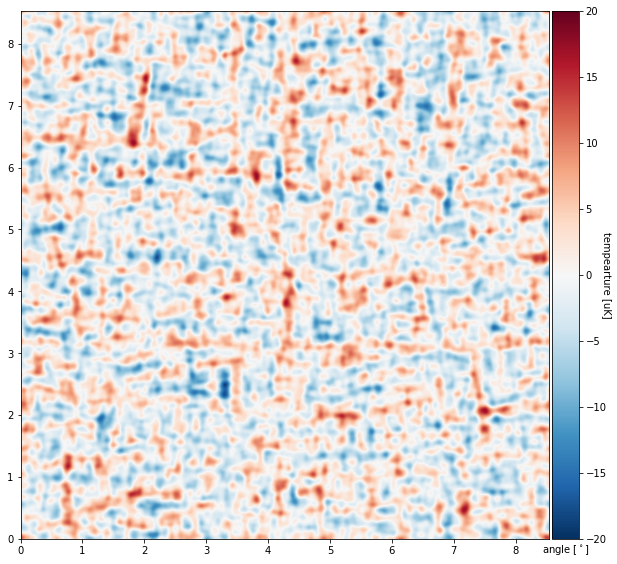

map mean: 0.19165109977077735 map rms: 4.405770437116259


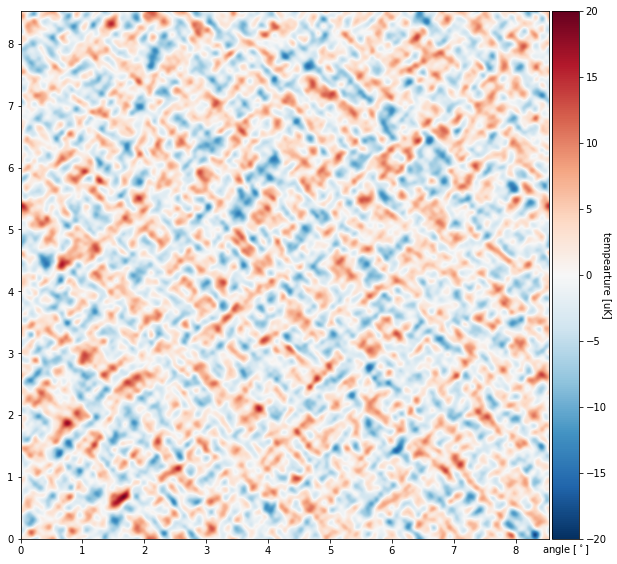

map mean: 0.19165109977077735 map rms: 6.331580870469541


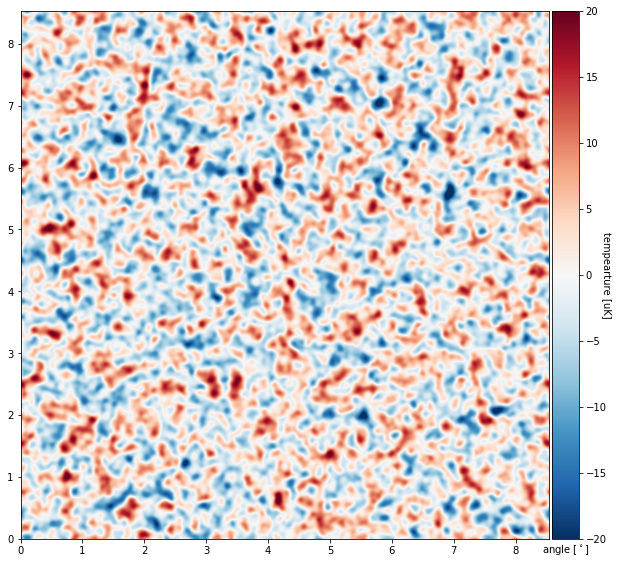

map mean: 0.09252002886916395 map rms: 0.49358204000419725


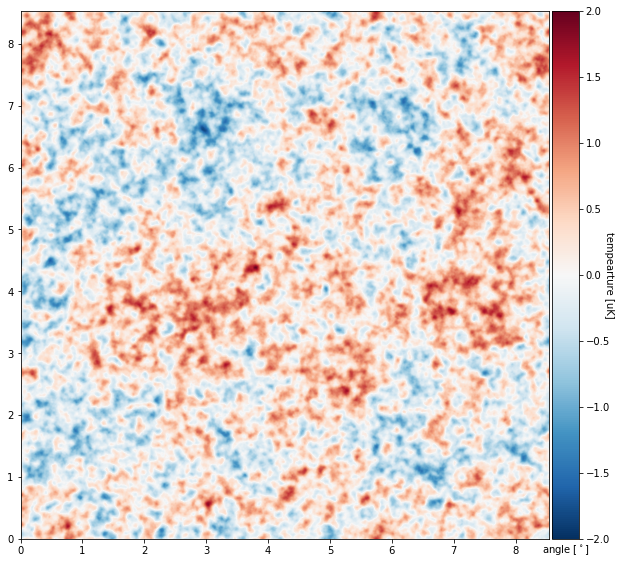

In [4]:
def make_CMB_maps(N,pix_size,ell,DlTT,DlEE,DlTE,DlBB):
    "makes a realization of a simulated CMB sky map"

    # convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClEE = DlEE * 2 * np.pi / (ell*(ell+1.))
    ClTE = DlTE * 2 * np.pi / (ell*(ell+1.))
    ClBB = DlBB * 2 * np.pi / (ell*(ell+1.))
    
    ## set the \ell = 0 and \ell =1 modes to zero as these are unmeasurmable and blow up with the above transform
    ClTT[0:1] = 0.
    ClEE[0:1] = 0.
    ClTE[0:1] = 0.
    ClBB[0:1] = 0.

    ## seperate the correlated and uncorrelated part of the EE spectrum
    correlated_part_of_E = ClTE / np.sqrt(ClTT)
    uncorrelated_part_of_EE = ClEE - ClTE**2. / ClTT
    
    correlated_part_of_E[0:1] = 0.
    uncorrelated_part_of_EE[0:1] = 0.
    

    # make a 2d coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    ang = np.arctan2(Y,X)   ## we now need this angle to handled the EB <--> QU rotation
    
    # now make a set of 2d CMB masks for the T, E, and B maps
    ell_scale_factor = 2. * np.pi / (pix_size/60. * np.pi/180.)
    ell2d = R * ell_scale_factor
    ClTT_expanded = np.zeros(int(ell2d.max())+1)
    ClTT_expanded[0:(ClTT.size)] = ClTT
    ClEE_uncor_expanded = np.zeros(int(ell2d.max())+1)
    ClEE_uncor_expanded[0:(uncorrelated_part_of_EE.size)] = uncorrelated_part_of_EE
    ClE_corr_expanded = np.zeros(int(ell2d.max())+1)
    ClE_corr_expanded[0:(correlated_part_of_E.size)] = correlated_part_of_E
    ClBB_expanded = np.zeros(int(ell2d.max())+1)
    ClBB_expanded[0:(ClBB.size)] = ClBB
    CLTT2d = ClTT_expanded[ell2d.astype(int)]
    ClEE_uncor_2d = ClEE_uncor_expanded[ell2d.astype(int)]
    ClE_corr2d = ClE_corr_expanded[ell2d.astype(int)]
    CLBB2d = ClBB_expanded[ell2d.astype(int)]
    
    # now make a set of gaussin random fields that will be turned into the CMB maps
    ramdomn_array_for_T = np.fft.fft2(np.random.normal(0,1,(N,N)))
    ramdomn_array_for_E = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    ramdomn_array_for_B = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    ## make the T, E, and B maps by multiplyign the masks against the random fields
    FT_2d = np.sqrt(CLTT2d) * ramdomn_array_for_T
    FE_2d = np.sqrt(ClEE_uncor_2d) * ramdomn_array_for_E + ClE_corr2d* ramdomn_array_for_T
    FB_2d = np.sqrt(CLBB2d) * ramdomn_array_for_B
    
    ## now conver E abd B to Q and U
    FQ_2d = FE_2d* np.cos(2.*ang) - FB_2d * np.sin(2. *ang)
    FU_2d = FE_2d* np.sin(2.*ang) + FB_2d * np.cos(2. *ang)
    
    ## convert from fourier space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) /(pix_size /60.* np.pi/180.)
    CMB_T = np.real(CMB_T)
    CMB_Q = np.fft.ifft2(np.fft.fftshift(FQ_2d)) /(pix_size /60.* np.pi/180.)
    CMB_Q = np.real(CMB_Q)
    CMB_U = np.fft.ifft2(np.fft.fftshift(FU_2d)) /(pix_size /60.* np.pi/180.)
    CMB_U = np.real(CMB_U)

    ## optional code for spitting out E and B maps 
    CMB_E = np.fft.ifft2(np.fft.fftshift(FE_2d)) /(pix_size /60.* np.pi/180.)
    CMB_E = np.real(CMB_E)
    CMB_B = np.fft.ifft2(np.fft.fftshift(FB_2d)) /(pix_size /60.* np.pi/180.)
    CMB_B = np.real(CMB_B)
    
    ## return the maps
    return(CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B)
  ###############################


    
## make a CMB T map
CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B = make_CMB_maps(N,pix_size,ell,DlTT,DlEE,DlTE,DlBB)


p = Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)
p = Plot_CMB_Map(CMB_Q,c_min/20.,c_max/20.,X_width,Y_width)
p = Plot_CMB_Map(CMB_U,c_min/20.,c_max/20.,X_width,Y_width)
p = Plot_CMB_Map(CMB_E,c_min/20.,c_max/20.,X_width,Y_width)
p = Plot_CMB_Map(CMB_B,c_min/200.,c_max/200.,X_width,Y_width)

Note the RMS of these maps: the T is ~100 $\mu$K, the Q and U are ~ 4.5 $\mu$K, the E is ~ 6.5 $\mu$K, and the B map rms is $<1 \mu K$.  Knowing these values is a good useful starting point for debuging simulations, calibration of real maps, and tracking the impact of filtering on maps.

<font color='red'>EXCERCISE: </font>  Add point sources and the SZ to these maps, next convolve with a beam, and add instrumental noise.   Assume the point sources have a fixed $3\%$ polarization fraction with random polarization angles and the SZ is fully unpolarized.  The noise in the polarization maps is $\sqrt 2$ larger than the temperature noise.

In [5]:
## your code goes here

<font color='red'>EXCERCISE: </font>  Calculate the BB power spectra using the code and Monte Carlo techniques we explored in Part Four.  Compare your results to the input spectra. Make sure to include a window funciton.   

In [6]:
## your code goes here

your notes go here

<font color='red'>EXCERCISE: </font>  Create a simualted map with $C_\ell^{BB} = 0$ Calculate the BB power spectra of this map using the estimates for the multiplicitive and addative bias you calcualted in the previous excercise with non-zero $C_\ell^{BB}$.   Why isn't your result consisitnat with $C_\ell^{BB} = 0$   

In [7]:
## your code goes here

your notes go here

<font color='red'>EXCERCISE: </font>  Calculate the TE power specturm by addapting the techniques from Part Four.

In [8]:
## your code goes here

your notes go here

## Kendrick Smith's no-leak B-mode estimator

Kendrick Smith wrote a nice <a href=https://arxiv.org/abs/astro-ph/0511629>paper</a> describing his solution to the E-B mixing problem on cut skys.  He showed that the leakage is realted to the window function used to apodize the maps before moving to fourier space and identified corrections (products of derivitives of the window funciton and the Q and U maps in fourier space) that can be added to create a clean estimte of the B-mode.

We implement his method here So that you can apply it to your simulations and see that it cleans up the B-mode estimate you produced above.

map mean: 14.384431866392228 map rms: 50.20841863112105


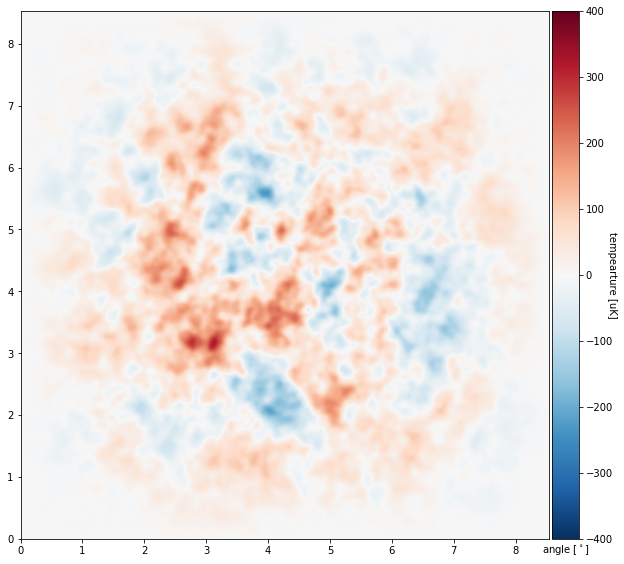

map mean: 0.07603890682227245 map rms: 3.167603506314644


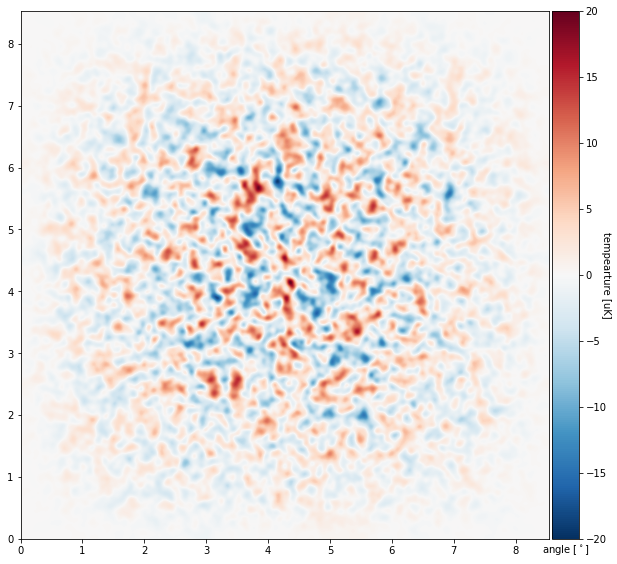

map mean: 0.06496130034274936 map rms: 0.2481144508125816


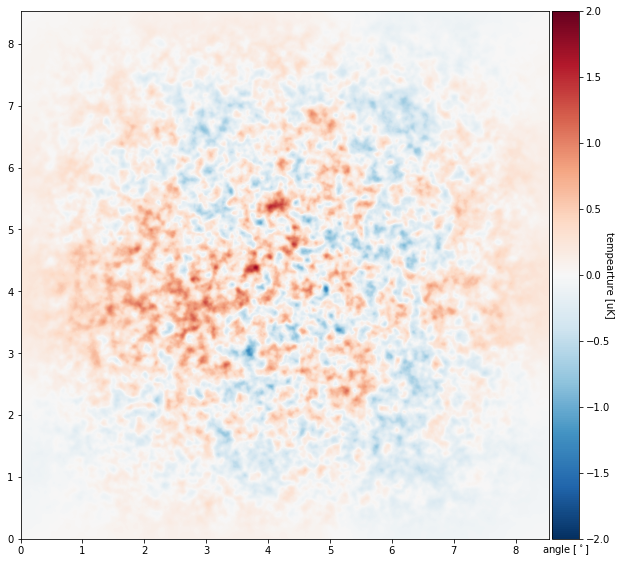

In [9]:
def kendric_method_precompute_window_derivitives(win,pix_size):
    delta = pix_size * np.pi /180. /60.
    dwin_dx =    ((-1.) * np.roll(win,-2,axis =1)      +8. * np.roll(win,-1,axis =1)     - 8. *np.roll(win,1,axis =1)      +np.roll(win,2,axis =1) ) / (12. *delta)
    dwin_dy =    ((-1.) * np.roll(win,-2,axis =0)      +8. * np.roll(win,-1,axis =0)     - 8. *np.roll(win,1,axis =0)      +np.roll(win,2,axis =0) ) / (12. *delta)
    d2win_dx2 =  ((-1.) * np.roll(dwin_dx,-2,axis =1)  +8. * np.roll(dwin_dx,-1,axis =1) - 8. *np.roll(dwin_dx,1,axis =1)  +np.roll(dwin_dx,2,axis =1) ) / (12. *delta)
    d2win_dy2 =  ((-1.) * np.roll(dwin_dy,-2,axis =0)  +8. * np.roll(dwin_dy,-1,axis =0) - 8. *np.roll(dwin_dy,1,axis =0)  +np.roll(dwin_dy,2,axis =0) ) / (12. *delta)
    d2win_dxdy = ((-1.) * np.roll(dwin_dy,-2,axis =1)  +8. * np.roll(dwin_dy,-1,axis =1) - 8. *np.roll(dwin_dy,1,axis =1)  +np.roll(dwin_dy,2,axis =1) ) / (12. *delta)
    return(dwin_dx,dwin_dy,d2win_dx2,d2win_dy2,d2win_dxdy)

def kendrick_method_TQU_to_fourier_TEB(N,pix_size,Tmap,Qmap,Umap,window,dwin_dx,dwin_dy,d2win_dx2,d2win_dy2,d2win_dxdy):
    ### the obvious FFTs
    fft_TxW = np.fft.fftshift(np.fft.fft2(Tmap * window))
    fft_QxW = np.fft.fftshift(np.fft.fft2(Qmap * window))
    fft_UxW = np.fft.fftshift(np.fft.fft2(Umap * window))

    ### the less obvious FFTs that go into the no-leak estiamte
    fft_QxdW_dx = np.fft.fftshift(np.fft.fft2(Qmap * dwin_dx))
    fft_QxdW_dy = np.fft.fftshift(np.fft.fft2(Qmap * dwin_dy))
    fft_UxdW_dx = np.fft.fftshift(np.fft.fft2(Umap * dwin_dx))
    fft_UxdW_dy = np.fft.fftshift(np.fft.fft2(Umap * dwin_dy))
    fft_QU_HOT  = np.fft.fftshift(np.fft.fft2( (2. * Qmap * d2win_dxdy) + Umap * (d2win_dy2 - d2win_dx2) ))
    
    ### generate the polar coordinates needed to cary out the EB-QU conversion
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2. + 1e-9)  ## the small offset regularizes the 1/ell factors below
    ang =  np.arctan2(Y,X)
    ell_scale_factor = 2. * np.pi / (pix_size/60. * np.pi/180.)
    ell2d = R * ell_scale_factor
        
    #p=Plot_CMB_Map(np.real( ang),-np.pi,np.pi,N,N)
    
    
    ### now compute the estimator
    fTmap = fft_TxW
    fEmap = fft_QxW * np.cos(2. * ang) + fft_UxW * np.sin(2. * ang)
    fBmap = (fft_QxW * (-1. *np.sin(2. * ang)) + fft_UxW * np.cos(2. * ang))  ## this line is the nominal B estimator
    fBmap = fBmap - complex(0,2.) / ell2d * (fft_QxdW_dx * np.sin(ang) + fft_QxdW_dy * np.cos(ang))
    fBmap = fBmap - complex(0,2.) / ell2d * (fft_UxdW_dy * np.sin(ang) - fft_UxdW_dx * np.cos(ang))
    fBmap = fBmap +  ell2d**(-2.) * fft_QU_HOT

    ### return the complex fourier maps in 2d
    return(fTmap,fEmap,fBmap)

    
    
dwin_dx,dwin_dy,d2win_dx2,d2win_dy2,d2win_dxdy = kendric_method_precompute_window_derivitives(window,pix_size)

### plots of the window function derivatives
#p=Plot_CMB_Map(dwin_dx,-10,10,X_width,Y_width)
#p=Plot_CMB_Map(dwin_dy,-10,10,X_width,Y_width)
#p=Plot_CMB_Map(d2win_dx2,-10,10,X_width,Y_width)
#p=Plot_CMB_Map(d2win_dy2,-10,10,X_width,Y_width)
#p=Plot_CMB_Map(d2win_dxdy,-10,10,X_width,Y_width)

fTmap,fEmap,fBmap = kendrick_method_TQU_to_fourier_TEB(N,pix_size,CMB_T,CMB_Q,CMB_U,window,dwin_dx,dwin_dy,d2win_dx2,d2win_dy2,d2win_dxdy)

p=Plot_CMB_Map(np.real( (np.fft.ifft2(np.fft.fftshift(fTmap)))),c_min,c_max,X_width,Y_width)
p=Plot_CMB_Map(np.real( (np.fft.ifft2(np.fft.fftshift(fEmap)))),c_min/20.,c_max/20.,X_width,Y_width)
p=Plot_CMB_Map(np.real( (np.fft.ifft2(np.fft.fftshift(fBmap)))),c_min/200.,c_max/200.,X_width,Y_width)

<font color='red'>EXCERCISE: </font>  Calculate the TT, EE, BB, TE, TB, and EB power spectra using the code and techniques we explored in Part Four but with the Kendrick-method for B-modes.  Compare your results to the input spectra and to the spectra you produced with the naive E-B separation.  Pay special attention to the angular scale dependence of the differences.

In [10]:
## your code goes here

your comments go here.